In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3. Libraries and raw data <a class="anchor" id="chapter_3"></a>

## 3.1 Libraries <a class="anchor" id="chapter_3_1"></a>

In [ ]:
!pip install tensorflow-io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 12.5 MB/s eta 0:00:00


In [ ]:
# basics
import os
import time
import numpy as np

# EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Data preprocessing
import tensorflow as tf
import tensorflow_io as tfio
from sklearn.model_selection import train_test_split

# Deep learning
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# utilities
from tensorflow.keras.models import load_model

## 3.2 Raw Data <a class="anchor" id="chapter_3_2"></a>

In [ ]:
# Print list of files and directories in folder
input_dir = '/content/drive/MyDrive/plant-pathology-2020-fgvc7'
files_dirs = [os.path.join(input_dir, x) for x in os.listdir(input_dir)]
files_dirs

['/content/drive/MyDrive/plant-pathology-2020-fgvc7/train.csv',
 '/content/drive/MyDrive/plant-pathology-2020-fgvc7/test.csv',
 '/content/drive/MyDrive/plant-pathology-2020-fgvc7/sample_submission.csv',
 '/content/drive/MyDrive/plant-pathology-2020-fgvc7/images']

In [ ]:
# Set datasets and directory names
sample_data = pd.read_csv(files_dirs[2])
train_data = pd.read_csv(files_dirs[0])
test_data = pd.read_csv(files_dirs[1])
image_dir = files_dirs[3] + '/'

In [ ]:
# Cleaning
del files_dirs

# 4. Exploratory data analysis <a class="anchor" id="chapter_4"></a>

## 4.1 Short datasets summary <a class="anchor" id="chapter_4_1"></a>

Both the training and testing tables have an 'image_id' column, which stores the image file names. In the next section, we'll use this column to get the images we need.

In [ ]:
def print_short_summary(name, data):
    """
    Print data head, shape and info.

    Args:
        name (str): name of dataset
        data (dataframe): dataset in a pd.DataFrame format
    """
    print(name)
    print('\n1. Data head:')
    print(data.head())
    print('\n2. Data shape: {}'.format(data.shape))
    print('\n3. Data info:')
    data.info()

def print_number_files(dirpath):
    print('{}: {} files'.format(dirpath, len(os.listdir(dirpath))))

In [ ]:
print_short_summary('Train data', train_data)

Train data

1. Data head:
  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

2. Data shape: (1821, 5)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB


In [ ]:
print_short_summary('Test data', test_data)

Test data

1. Data head:
  image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4

2. Data shape: (1821, 1)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  1821 non-null   object
dtypes: object(1)
memory usage: 14.4+ KB


In [ ]:
print_short_summary('Sample data', sample_data)

Sample data

1. Data head:
  image_id  healthy  multiple_diseases  rust  scab
0   Test_0     0.25               0.25  0.25  0.25
1   Test_1     0.25               0.25  0.25  0.25
2   Test_2     0.25               0.25  0.25  0.25
3   Test_3     0.25               0.25  0.25  0.25
4   Test_4     0.25               0.25  0.25  0.25

2. Data shape: (1821, 5)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   image_id           1821 non-null   object 
 1   healthy            1821 non-null   float64
 2   multiple_diseases  1821 non-null   float64
 3   rust               1821 non-null   float64
 4   scab               1821 non-null   float64
dtypes: float64(4), object(1)
memory usage: 71.3+ KB


In [ ]:
print_number_files(image_dir)

/content/drive/MyDrive/plant-pathology-2020-fgvc7/images/: 3642 files


In [ ]:
# Cleaning
del print_short_summary, print_number_files

## 4.2 Number of records per label <a class="anchor" id="chapter_4_2"></a>

Our data is unevenly distributed among classes, which could affect our neural networks' learning. To fix this, we'll increase the number of samples in smaller classes to match the larger ones. With additional regularization this will help our networks learn better and make more accurate predictions, lowering the risk of overfitting.

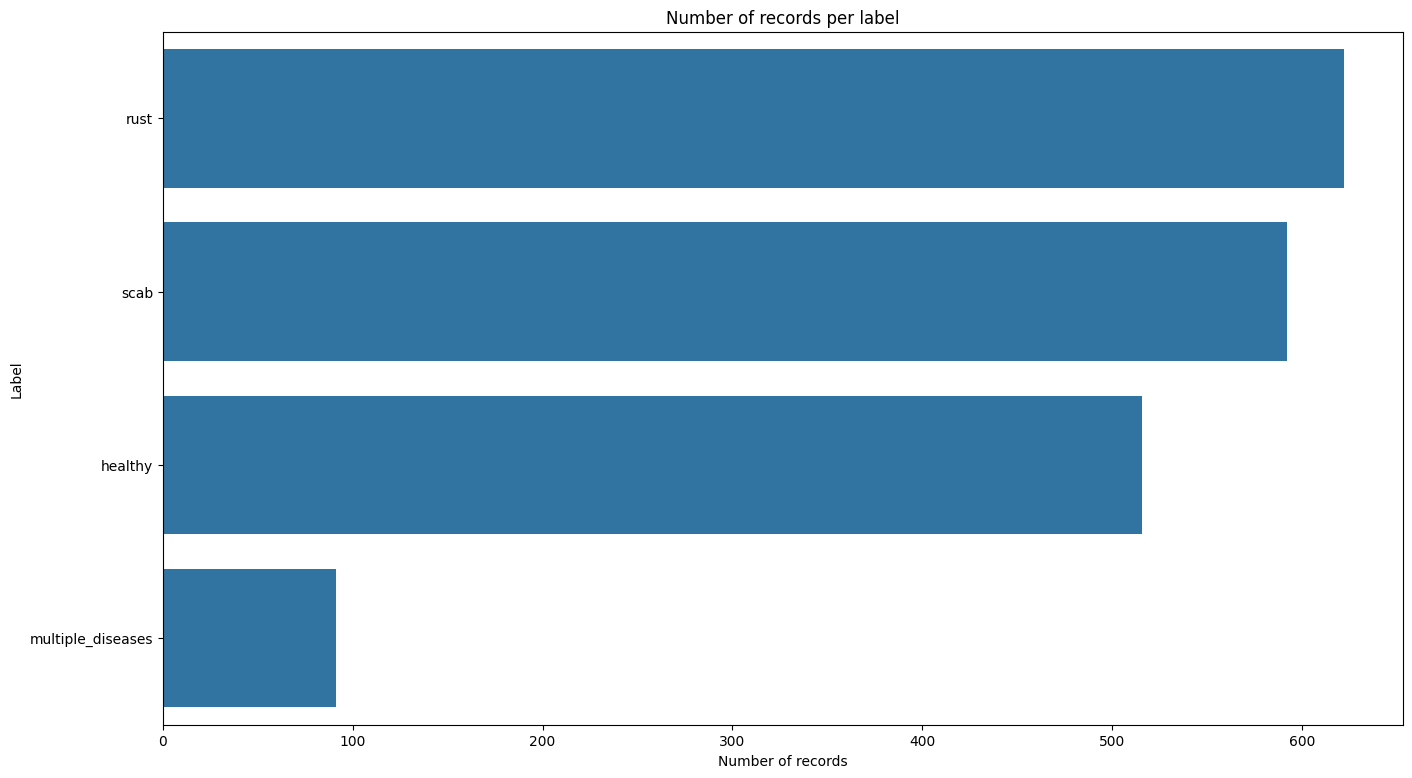

In [ ]:
# Plot horizontal barplot of number of records per label
plt.figure(figsize=(16, 9))
tmp = train_data.iloc[:, 1:].sum().values
tmp = pd.DataFrame(tmp, train_data.columns[1:]).sort_values(by=[0], ascending = False)
sns.barplot(y = tmp.index, x = np.ravel(tmp.values), orient='h')
plt.xlabel('Number of records')
plt.ylabel('Label')
plt.title('Number of records per label')
plt.show()

## 4.3 Images <a class="anchor" id="chapter_4_3"></a>

In [ ]:
def get_images_to_plot(file_names):
    """
    Return list of image objects.

    Args:
        file_names: list of filenames
    Returns:
        list: list of image objects
    """
    return [Image.open(f) for f in file_names]

def get_image_label(dirname, data, labels, n = 5):
    """
    Return dictionary with label-imagepath.

    Args:
        dirname: name of the directory
        data: dataset of file names
        labels: list of labels
        n (opt): number of images per label
    Returns:
        dict: dictionary with label-imagepath pairs
    """
    dict_img = {}
    for l in labels:
        indexes = data[l] == 1
        tmp = data[indexes][:n]
        tmp = dirname + tmp['image_id'] + '.jpg'
        tmp = tmp.values
        tmp = get_images_to_plot(tmp)
        dict_img[l] = tmp

    return dict_img

In [ ]:
# Print original image size
img_path = image_dir + train_data['image_id'][0] + '.jpg'
img = Image.open(img_path)
print('Original image size: {}'.format(img.size))

Original image size: (2048, 1365)


In [ ]:
# Get 5 filenames per label
data = get_image_label(image_dir, train_data, tmp.index)

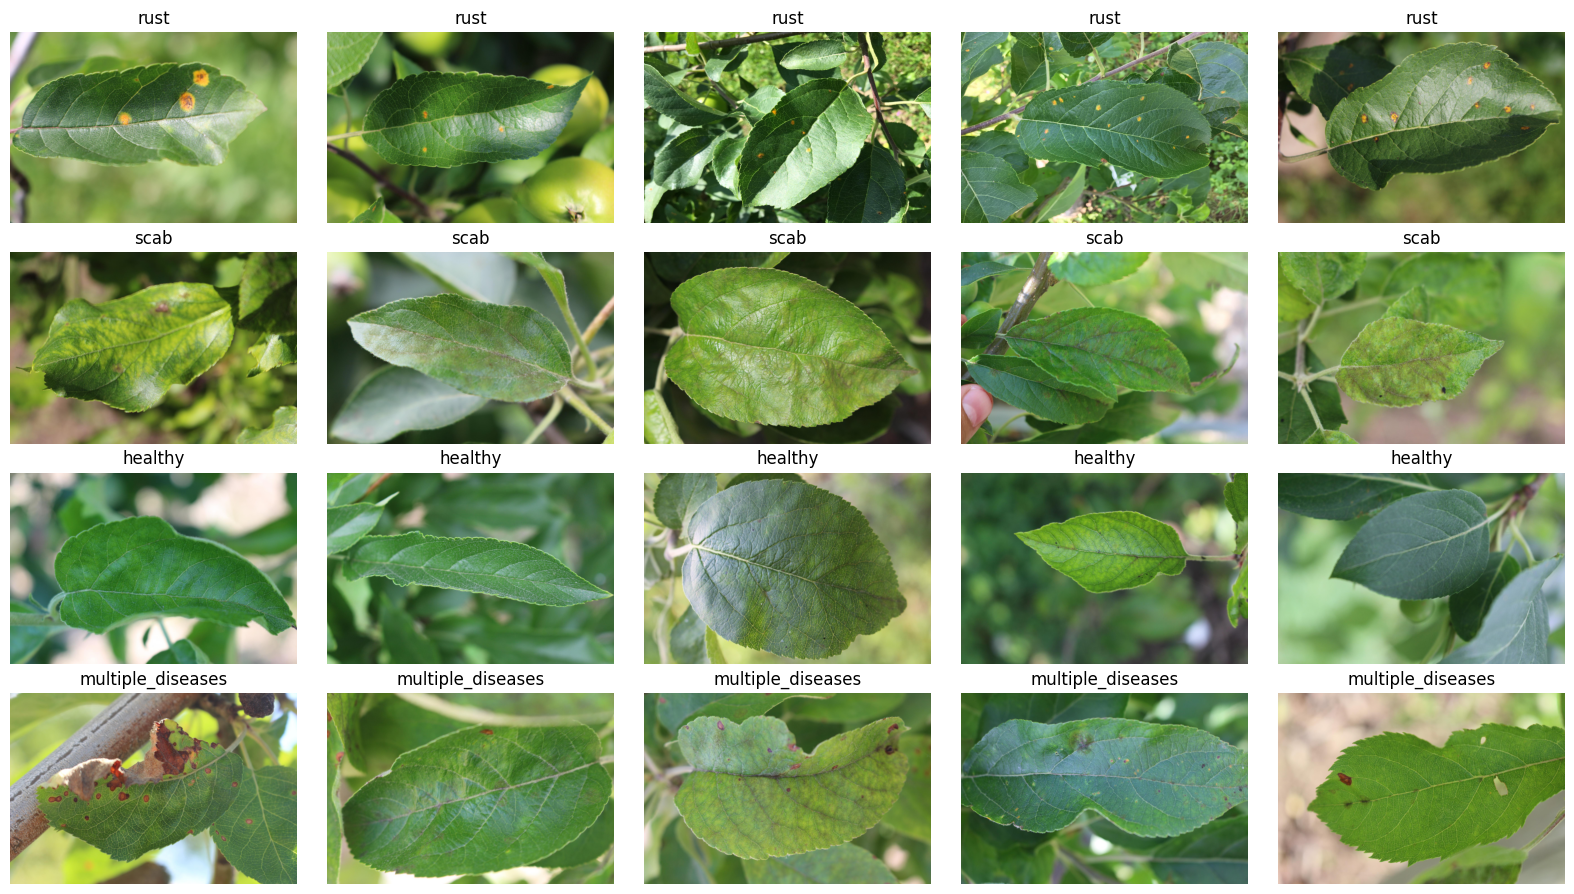

In [ ]:
# Initialize subplots with number of labels rows and 5 columns
fig, axes = plt.subplots(nrows=len(tmp.index), ncols=5, figsize=(16, 9))

# Loop through selected images and display in the respective rows
labels = tmp.index
for i in range(len(labels)*5):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(data[labels[row]][col])
    axes[row, col].set_title(labels[row])
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Cleaning
del get_images_to_plot, get_image_label, img_path, img
del data, fig, axes, labels, row, col

# 5 Data preprocessing <a class="anchor" id="chapter_5"></a>

In [ ]:
# Global configuration
BATCH_SIZE = 32
NUM_CLASSES = 4
NUM_EPOCHS = 25
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224

## 5.1 Upsampling <a class="anchor" id="chapter_5_1"></a>

This section aims to balance the class distribution in the training dataset by upsampling the minority classes.

In [ ]:
# Get class distribution
class_counts = train_data.iloc[:, 1:].sum()

# Get maximum count of the majority class
max_count = class_counts.max()

# Upsample the minority classes to the max_count records
balanced_data = []
for class_name in class_counts.index:
    class_data = train_data[train_data[class_name] == 1]
    upsampled_data = class_data.sample(max_count
                                         , replace = True
                                         , random_state = 0)
    balanced_data.append(upsampled_data)

# Get final balanced dataframe
train_data_balanced = pd.concat(balanced_data, axis=0, ignore_index=True)
train_data_balanced.iloc[:, 1:].sum()

,0
healthy,622
multiple_diseases,622
rust,622
scab,622


## 5.2 Data augmentation <a class="anchor" id="chapter_5_2"></a>

Data augmentation in our task of image classification is crucial for two main reasons:

1. Increased Diversity: augmenting the data with various transformations provides a wider range of image variations, helping the model generalize better to unseen data.
2. Preventing Overfitting: it acts as a regularizer, reducing overfitting risk by exposing the model to diverse training instances.

In [ ]:
def get_augmented_image(image):
    """
    Return augmented image.

    Args:
        image: image tensor
    Returns:
        image
    """
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    return image

## 5.3 Train-test split <a class="anchor" id="chapter_5_3"></a>

In [ ]:
# Get image paths and labels
image_paths = image_dir + train_data_balanced['image_id'] + '.jpg'
image_paths = image_paths.values
labels = train_data_balanced.loc[:, 'healthy':]

# Split into train and test sets fo training accuracy
X_train, X_test, y_train, y_test = train_test_split(image_paths
                                                    , labels
                                                    , test_size = 0.25
                                                    , shuffle = True
                                                    , random_state = 43)

In [ ]:
del image_paths, labels

## 5.4 Parallel preprocessing <a class="anchor" id="chapter_5_4"></a>

We're going to incorporate Tensorflow parallel processing functions to use optimal number of CPU cores provided in this notebook.

In [ ]:
def get_decoded_image(image_path, label = None):
    """
    Load and preprocess images using TensorFlow I/O
    and Image Generator transformation.

    Args:
        image_path: path to JPEG image
    Returns:
        image or tuple: decoded image or (image, label)
    """
    image = tf.io.read_file(image_path)
    # Set 3 channels, RGB
    image = tf.image.decode_image(image, channels=3)
    image.set_shape([None, None, 3])
    # Set size to convert to compatible with models input
    image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    image = tf.cast(image, tf.float32) / 255.0
    image = get_augmented_image(image)

    return image if label is None else (image, label)


def get_prefetched_data(data):
    """
    Create a TensorFlow dataset from image paths.
    Execution in parallel.
    Load, preprocess images and batch the data.
    Prefetch batches to improve training performance.

    Args:
        data: ndarray of image paths + labels (opt)
    Returns:
        tf.data.Dataset: preprocessed and preloaded TensorFlow dataset for keras NN
    """
    # Autotune the degree of parallelism during training
    AUTOTUNE = tf.data.experimental.AUTOTUNE

    # Create dataset from image paths
    dataset = tf.data.Dataset.from_tensor_slices(data)

    # Apply parallel processing to load and preprocess images
    dataset = dataset.map(get_decoded_image, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset

In [ ]:
# Get prefetched tf.data.DataSet for subsequent models
train_dataset = get_prefetched_data((X_train, y_train))
test_dataset = get_prefetched_data((X_test, y_test))

# 6. Model architecture<a class="anchor" id="chapter_6"></a>

In [ ]:
def get_model(Model):
    """
    Return Model architecture.

    Args:
        obj: model class
    Returns:
        obj: model architecture
    """
    model = Model(weights='imagenet'
                     , include_top=False
                     , input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

    return model

def get_model_resnet():
    return get_model(ResNet50)

def get_model_vggnet():
    return get_model(VGG16)

def get_model_inceptionnet():
    return get_model(InceptionV3)

In [ ]:
def get_compiled_model(func):
    """
    Return model to be trained with a multi-GPU strategy.
    Allows data parallelism by copying all of the model's variables
    to each processor.

    Args:
        func: function to get model architecture
    Returns:
        compiled_model: tensorflow model
    """
    # Check if GPU is available
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        # Create a MirroredStrategy.
        strategy = tf.distribute.MirroredStrategy()

        print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    else:
        strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
        print('No GPU available, falling back to CPU.')

    with strategy.scope():
        compiled_model = func()
        # Add custom classification layers for our task
        compiled_model = Sequential([
            compiled_model
            , layers.GlobalAveragePooling2D()
            # Add dense layers with 128 and 64 units
            , layers.Dense(128, activation="relu")
            , layers.Dense(64, activation="relu")
            # Add regularization with dropout rate 30%
            , layers.Dropout(0.3)
            , layers.Dense(NUM_CLASSES, activation='softmax')
        ])
        compiled_model.compile(optimizer = 'adam'
                              , loss = 'categorical_crossentropy'
                              , metrics = ['categorical_accuracy'])

    return compiled_model

In [ ]:
def plot_model_scores(scores, model_name):
    """
    Plot train and test accuracy scores of a model by epoch
    """
    train_scores, test_scores = scores
    epochs = range(1, len(train_scores) + 1)

    # Plot train and test scores
    plt.figure(figsize=(16, 9))
    plt.plot(epochs, train_scores, label='Train score')
    plt.plot(epochs, test_scores, label='Test score')
    plt.title('Train and test accuracy scores of the {}'.format(model_name))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy Score')
    plt.legend()
    plt.grid(True)
    plt.show()


def get_model_results(model_name, model):
    """
    Return tuple of runtime, train and test scores.
    Compile, fit and save model along the way.

    Args:
        model: fitted model
    Returns:
        (runtime, (train_scores, test_scores) )
    """
    model = get_compiled_model(model)

    st = time.time()
    model.fit(train_dataset, epochs = NUM_EPOCHS, validation_data=test_dataset)
    runtime = time.time() - st

    model.save('{}.h5'.format(model_name))

    train_scores = model.history.history['categorical_accuracy']
    test_scores = model.history.history['val_categorical_accuracy']

    tf.keras.backend.clear_session()

    return (runtime, (train_scores, test_scores))

## VGG-Net <a class="anchor" id="chapter_7_2"></a>

In [ ]:
# Get train and test scores of every epoch
runtime_vggnet, scores_vggnet = get_model_results('model_vggnet'
                                                  ,get_model_vggnet)

Number of devices: 1
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - categorical_accuracy: 0.2469 - loss: 1.5940 - val_categorical_accuracy: 0.2106 - val_loss: 1.3989
Epoch 2/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - categorical_accuracy: 0.2336 - loss: 1.3946 - val_categorical_accuracy: 0.2106 - val_loss: 1.3894
Epoch 3/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 49s 830ms/step - categorical_accuracy: 0.2648 - loss: 1.3865 - val_categorical_accuracy: 0.2106 - val_loss: 1.3900
Epoch 4/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - categorical_accuracy: 0.2513 - loss: 1.3954 - val_categorical_accuracy: 0.2106 - val_loss: 1.3951
Epoch 5/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - categorical_accuracy: 0.2452 - loss: 1.3933 - val_categorical_accuracy: 0.2106 - val_loss: 1.3925
Epoch 6/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - categorical_accuracy: 0.2761 - loss: 1.3853 - val_categorical_accuracy: 0.2540 - val_loss: 1.3866
Epoch 7/25
59/59 ━━━━

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the saved InceptionNet model
model = load_model('model_vggnet.h5')

# Define the class labels
class_labels = ['healthy', 'multiple_diseases', 'rust', 'scab']

def predict_disease(image_path):
  """
  Predicts the plant disease based on the given image path.

  Args:
    image_path: The path to the image file.

  Returns:
    The predicted disease name.
  """

  # Load and preprocess the image
  img = image.load_img(image_path, target_size=(224, 224))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img / 255.0

  # Make the prediction
  prediction = model.predict(img)
  predicted_class_index = np.argmax(prediction)
  predicted_disease = class_labels[predicted_class_index]

  return predicted_disease

# Example usage:
image_path = '/content/drive/MyDrive/plant-pathology-2020-fgvc7/images/Test_1005.jpg'  # Replace with the actual path to your image
predicted_disease = predict_disease(image_path)
print(f"Predicted Disease: {predicted_disease}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Disease: healthy


In [ ]:
from sklearn.metrics import classification_report
# ... (other code) ...

# Load the ResNet model
model = load_model('model_vggnet.h5')

# Get predictions for the test dataset
y_pred = model.predict(test_dataset)
# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true_classes = np.argmax(y_test.values, axis=1)

# Print the classification report
print(classification_report(y_true_classes, y_pred_classes))

20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 526ms/step
              precision    recall  f1-score   support

           0       0.21      1.00      0.35       131
           1       0.00      0.00      0.00       167
           2       0.00      0.00      0.00       166
           3       0.00      0.00      0.00       158

    accuracy                           0.21       622
   macro avg       0.05      0.25      0.09       622
weighted avg       0.04      0.21      0.07       622



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step


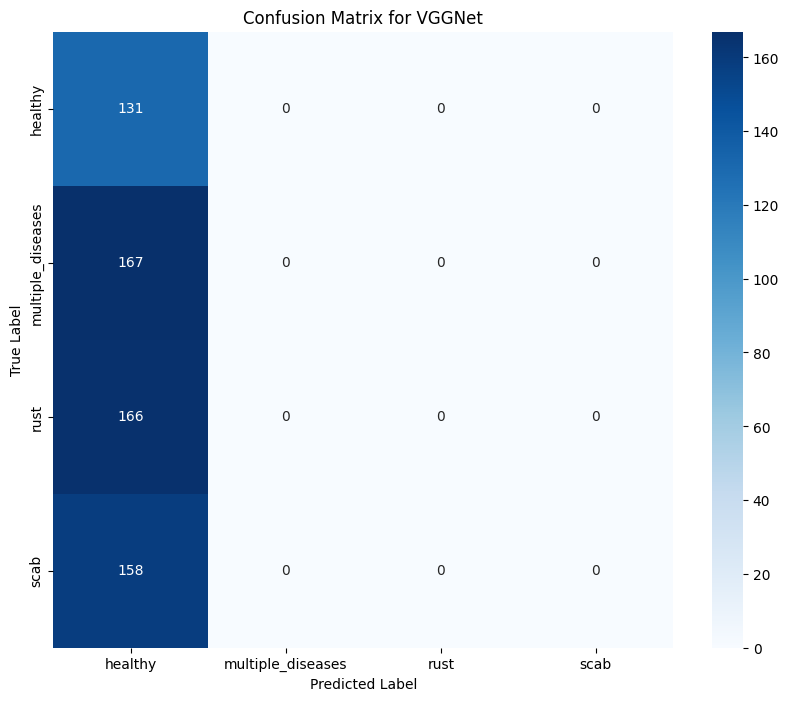

In [ ]:
model = load_model('model_vggnet.h5')
# Get predictions for the test dataset
y_pred = model.predict(test_dataset)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true_classes = np.argmax(y_test.values, axis=1)
# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Define class names (order should match model's output)
class_names = ['healthy', 'multiple_diseases', 'rust', 'scab']

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for VGGNet') # Update the title
plt.show()

In [ ]:
from sklearn.metrics import precision_score
# ... (other code) ...

# Load the VGGNet model
model = load_model('model_vggnet.h5')

# Get predictions for the test dataset
y_pred = model.predict(test_dataset)
# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true_classes = np.argmax(y_test.values, axis=1)

# Calculate and print precision
precision = precision_score(y_true_classes, y_pred_classes, average='macro')
print(f"VGGNet Precision: {precision:.4f}") # Updated print statement

20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step
VGGNet Precision: 0.0527


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import recall_score
# ... (other code) ...

# Load the ResNet model
model = load_model('model_vggnet.h5')

# Get predictions for the test dataset
y_pred = model.predict(test_dataset)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true_classes = np.argmax(y_test.values, axis=1)

# Calculate and print recall
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
print(f"VGGNET Recall: {recall:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step
VGGNET Recall: 0.2500


In [ ]:
from sklearn.metrics import f1_score
# ... (other code) ...

# Load the ResNet model
model = load_model('model_vggnet.h5')

# Get predictions for the test dataset
y_pred = model.predict(test_dataset)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true_classes = np.argmax(y_test.values, axis=1)

# Calculate and print F1-score
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
print(f"VGGNet F1-score: {f1:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 597ms/step
VGGNet F1-score: 0.0870


In [ ]:
from sklearn.metrics import accuracy_score
# ... (other code) ...

# Load the ResNet model
model = load_model('model_vggnet.h5')

# Get predictions for the test dataset
y_pred = model.predict(test_dataset)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true_classes = np.argmax(y_test.values, axis=1)

# Calculate and print accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"VGGNet Accuracy: {accuracy:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step
VGGNet Accuracy: 0.2106


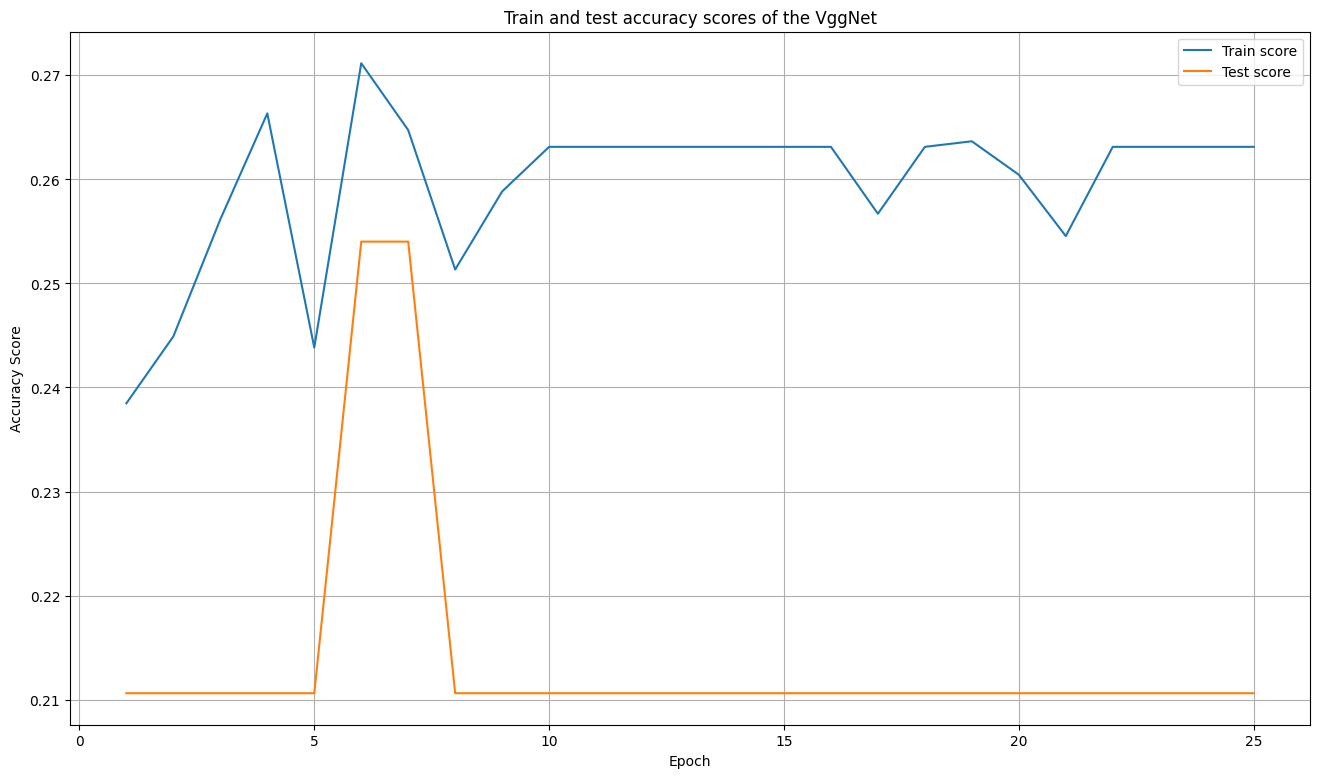

In [ ]:
# Plot scores
plot_model_scores(scores_vggnet, 'VggNet')